In [24]:
import gymnasium as gym
from IPython.display import display, clear_output, Image
import pathlib
import sys
import torch
from torch.utils.tensorboard import SummaryWriter
import tqdm
sys.path.insert(0, str(pathlib.Path("../..").absolute()))

from environment import TreeEnv
from analysis import DataLogger, SystemMetrics, LearningMetrics, plot_system_metrics, plot_train_metrics
from computation_sim.system import SystemDrawer, GifCreator
from computation_sim.time import FixedDuration, GaussianTimeSampler, GammaDistributionSampler
from agents.q_agent import DQNActor
import numpy as np
import matplotlib.pyplot as plt


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = pathlib.Path("models")
MODEL_PATH.mkdir(exist_ok=True)
LOG_PATH = pathlib.Path("logs")
LOG_PATH.mkdir(exist_ok=True)
IMG_PATH = pathlib.Path("images")
IMG_PATH.mkdir(exist_ok=True)
print(f"Using device: {DEVICE}")


Using device: cuda


# Simple Tree Environment: DQN
This is an introductory notebook showing how to set-up and control a simple compute scheduling environment called "Simple Tree". The following tiles will

- Set-up the "Simple Tree Environment": Show how to configure, initialize and visualize the environment.

- Set-up a simple DQN-Agent.

- Train the agent on the environment and play around with some parameters.



## Setting up the Environment
The next tile shows a schematic representation of the "Simple Tree" environment. Let us first have a look at the topology of this environment (checkout the block diagram displayed by the next tile).

### System Topology
There are five source nodes (`SOURCE_0-4`) that periodically output messages. Each source sends its output to a FIFO ring buffer node with capacity one (`BUFFER_0-4`). Upon activation, the `COMPUTE` node pops all buffers (that is, it empties and reads them) and performs computations on the data. Once these computations complete, the node forwards the result to an output node.

So far, we discussed the happy path, but messages can get lost in the system.
- If a buffer is not popped before the next message arrives, the older message is sent to a sink-node called `LOST_BUFFER`. This is a symbolic node that makes it easy for us to count the number of lost messages.
- The compute node makes sure its inputs are synchronized in time. Messages that are too old will not be used for computations. Instead, these messages are forwarded to the `LOST_COMPUTE` sink node. The exact meachnism for input rejection is not of relevance, but in case you're interested, checkout the [filtering_miso_node](../../computation_sim/nodes/filtering_miso_node.py).

### Actions and Rewards
Our main objective is to minimize the amount of information lost in the system. Each message lost results in adding `-1.0` to the reward. Depending on the system parameters, there might be multiple optimal policies. Thus, we add two regularization objectives:
- We slightly punish the age of the oldest information in the system output. This should favor policies that cause up-to-date information in system outputs.
- We slightly punish each input activation. This should cause the agent to not trigger any action, if the compute node is busy.

There is a single action in this system, which is the activation of the compute process. The optimal policy is a policy that minimizes the message loss in the system, by triggering the compute task at the correct moments in time.

### Setting up the System
We use the [gymnasium.Env](https://gymnasium.farama.org/api/env/) API, because it allows us to cleanly separate an agent from its environment. Further, it is the defacto standard, which guarantees compatibility with off-the-shelf agents. In [environment.py](environment.py) we put together the environment, by using the basic build blocks from the  [computation_sim](../../computation_sim/__init__.py) package.

In [32]:
# We have a discrete time system with a time step of 10ms
dt = 10 

# Set-up some default parameters
params = {
    "environment" : {
        "num_sensors": 5, # Number of sources
        "dt": dt, 
        "cost_input": 0.01, # Regularization cost for input
        "cost_message_loss": 1.0, # Primary goal: Minimize message loss
        "cost_output_time": 0.1 / 100.0, # Secondary goal: Minimize age of oldest information in the output
        "filter_threshold": 50.0 # Threshold used by the compute node to reject messages
    },
    "agent" : {
        # We don't optimize the ANN at every time step to save compute. Instead, we do it every 100ms.
        "learn_period": int(100 / dt), 
        "memory_size": 2 * 60 * int(1_000 / dt), # Memory spans a range of 2 minutes,
        "tau" : dt / 2000.0, # Policy network updated after 2sec
        "batch_size" : 1024, # Number of samples used in one model update
        "gamma": 0.9, # Hyperparam; not really of used in continuous task, more of a tuning param
        "epsilon_start": 0.1, # Initial exploration rate
        "epsilon_end": 0.0, # Final exploration rate
        "epsilon_decay" : 4 * 60 * int(1_000 / dt), # Half-life of epsilon decay: 4 minutes
        "lr" : 1e-3, # Learning rate for the optimizer
    },
}

# Build the environment
env = TreeEnv(**params["environment"])

# Instantiate a plotly drawer to obtain an interactive visualization of the system
# You can hover over the nodes to see the messages and the state of the compute nodes!
drawer = SystemDrawer()
drawer.build(env.system.node_graph)
drawer.fw.update_layout(autosize=True, width=400, height=400)

# Show the initial state of the system
clear_output(wait=True)
display(drawer.fw)


FigureWidget({
    'data': [{'hoverinfo': 'none',
              'line': {'color': '#888', 'width': 1.0},
              'mode': 'lines',
              'showlegend': False,
              'type': 'scatter',
              'uid': '77f26c91-2023-4923-8016-d9cc593e6c6e',
              'x': [0.4642857142857143, 0.9642857142857143, None,
                    0.4642857142857143, 0.9642857142857143, None,
                    -0.5357142857142857, -0.035714285714285726, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.5357142857142857, -0.035714285714285726, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.5357142857142857, -0.035714285714285726, None,
                    -0.035714285714285726, 0.4642857142857143, None,
                    -0.035714285714285726, 0.464

## Agent
Next, we set up the Deep Q-Network (DQN) actor. The DQN agent we use is a fundamental implementation based on the original [DQN paper](https://arxiv.org/abs/1312.5602). Although it may not reflect the latest advancements in reinforcement learning, building the algorithm ourselves provides valuable learning opportunities. In a production environment, we would prefer to use standardized and well-tested implementations like those found in [stable-baselines](https://stable-baselines.readthedocs.io/en/master/index.html).


In [33]:
agent = DQNActor(
    num_states=env.observation_space.shape[0],
    num_actions=env.action_space.n,
    device=DEVICE,
    **params["agent"])

## Simulation Loop
The simulation loop runs an agent on the environment without optimizing the model. It will automatically create a `.gif` video of the agent evaluated on the system. You can set the `interactive` flag to true, if you want to interactively step through the simulation (press `enter` to advance the simulation by one step).

In [34]:

def simulate(agent: object, env: TreeEnv, num_steps: int, gif_creator: GifCreator, interactive = False):
    state, _ = env.reset()
    state = torch.tensor(state.data, dtype=torch.float32, device=DEVICE).unsqueeze(0)
    drawer = SystemDrawer()
    drawer.build(env.system.node_graph)
    gif_creator.update(drawer)
    result = []

    # Simulate and capture frames
    for i in range(num_steps):
        action = agent.epsilon_greedy(state)
        next_state, reward, _, _, info= env.step(action)
        state = torch.tensor(
            next_state.data, dtype=torch.float32, device=DEVICE
        ).unsqueeze(0)
        drawer.update(env.system.node_graph)

        if interactive:
            clear_output(wait=True)
            display(drawer.fw)
            input("<Press Enter to continue>")

        gif_creator.update(drawer)
        result.append(dict(
            step=i,
            reward=reward,
            **info
        ))
        
    return result


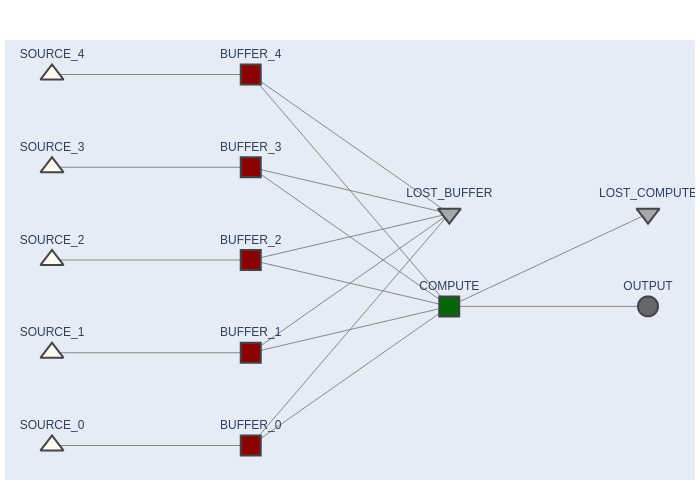

In [35]:
# Simulate system, create gif, display here
gif_creator = GifCreator()
simulate(agent, env, 100, gif_creator=gif_creator, interactive=False)
gif_creator.save(str(IMG_PATH / "agent_untrained.gif"), fps = 5)
with open(str(IMG_PATH / 'agent_untrained.gif'),'rb') as f:
    display(Image(data=f.read(), format='png'))


### Training Loop
The training loop is straighforward and the code should be self-explanatory.


In [36]:
def train(
    actor: DQNActor,
    env: gym.Env,
    num_sim_steps: int,
    optimize_period: int,
    logger: DataLogger = None,
    device: str = "cpu",
    reset: bool = True,
):
    # Initialize the environment
    if reset:
        state, _ = env.reset()
        state = torch.tensor(state.data, dtype=torch.float32, device=device).unsqueeze(0)
    else:
        state = env.state
        state = torch.tensor(state.data, dtype=torch.float32, device=device).unsqueeze(0)

    # Run training loop
    bar = tqdm.tqdm(range(num_sim_steps))
    for i_step in bar:
        # Take action, observe transition
        action = actor.epsilon_greedy(state)
        next_state, reward, _, _, info = env.step(action)

        # Update memory
        action = torch.tensor([[action]], device=device, dtype=torch.int64)
        next_state = torch.tensor(
            next_state.data, dtype=torch.float32, device=device
        ).unsqueeze(0)
        reward = torch.tensor([reward], device=device)
        actor.push_memory(state, action, next_state, reward)

        # Run learning algo
        if logger is not None:
            logger.log_system_metrics(env.time, SystemMetrics(**info))
        if i_step % optimize_period == 0:
            learning_info = actor.optimize_model()
            if len(learning_info) != 0 :
                logger.log_train_metrics(env.time, LearningMetrics(**learning_info, reward=reward.cpu().item()))
        logger.write_to_tensorboard()

        # Close loop
        state = next_state

### Initial Training Run
We can now start training our agent. To visualize the training metrics in realtime, open up a tensorboard with the following command `tensorboard --logdir code/notebooks/02_simple_tree/logs/`. Once the training was completed, two plots visualize the training metrics. Let's have a closer look at these results.

#### Loss Function
The first plot shows the training loss against simulated time. The loss is a function of the Belmann error:

$$
loss = \mathcal{L}\left(R_{t + 1} + \gamma \max_{a}\left(\hat{q}\left(S_t, a, \theta_{t, target}\right)\right), \hat{q}\left(S_t, A_t, \theta_{t, policy}\right)\right)
$$

where $\mathcal{L}$ is the [smooth L1-Loss](https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html) and $\theta_{policy}$ is the parameter vector under optimization. A large loss indicates a large absolute Belman error, which means that the ANN (Artificial Neural Network) is not yet a good approximation of the true value function. More policy iteration (improvement of the policy and the value function) is needed to find a better policy.

The loss shrinks drastically throughout the initial minute of simulated time. Following is a transient phase of about ten minutes, where the agent still seems to improve the value function. After minute ten, the loss is close to zero and only occasional events seem to reinforce an improvement of the value function.

#### Exploration Coefficient
The second plot shows the exploration coefficient used for the `\epsilon`-greedy action selection. The initial value of `0.1` means that one out of ten actions is chosen randomly. The coefficient decays exponentially to an asymptotic value of `0.0`. Due to the stochasticity of the system, an epsilon greedy action selection is not strictly needed. However, I found that the agent tends to learn faster with mild exploration. 

#### Reward Signal, Output Age, Message Loss
The third plot shows the reward signal over simulated time. This signal is directly linked to the information age at the output (plot four) and the number of lost messages (plot five).

Matching the loss function, we see an initial negative reward spike in the first minute of simulated time. This peak is caused by a high number of lost messages and the agent quickly learns to reduce the amount of lost messages, by triggering the compute task. Starting form minute one up until minute two, the agent plateaus at a local optimum. There are almost no message losses, the loss is almost zero, but the age of the output is quite high at about `180ms` of average age. Starting from minute two until about minute ten, the agent learns to reduce the age of the output. This is an exploratory phase, where the agent tries to trigger the compute task earlier. Sometimes it triggers the task too early, which causes occasional message losses. Starting from minute ten, the agent found a quasi-stable policy, reducing the message loss to almost zero. The output age settles at around `140ms`.

100%|██████████| 120000/120000 [00:47<00:00, 2513.49it/s]


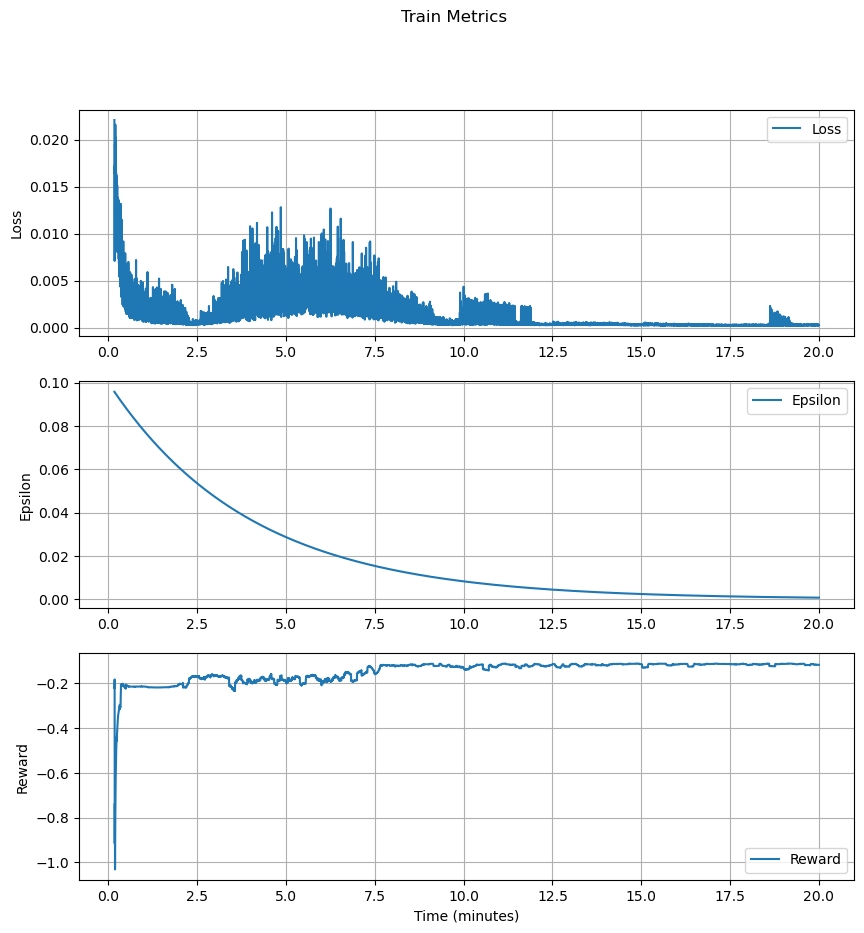

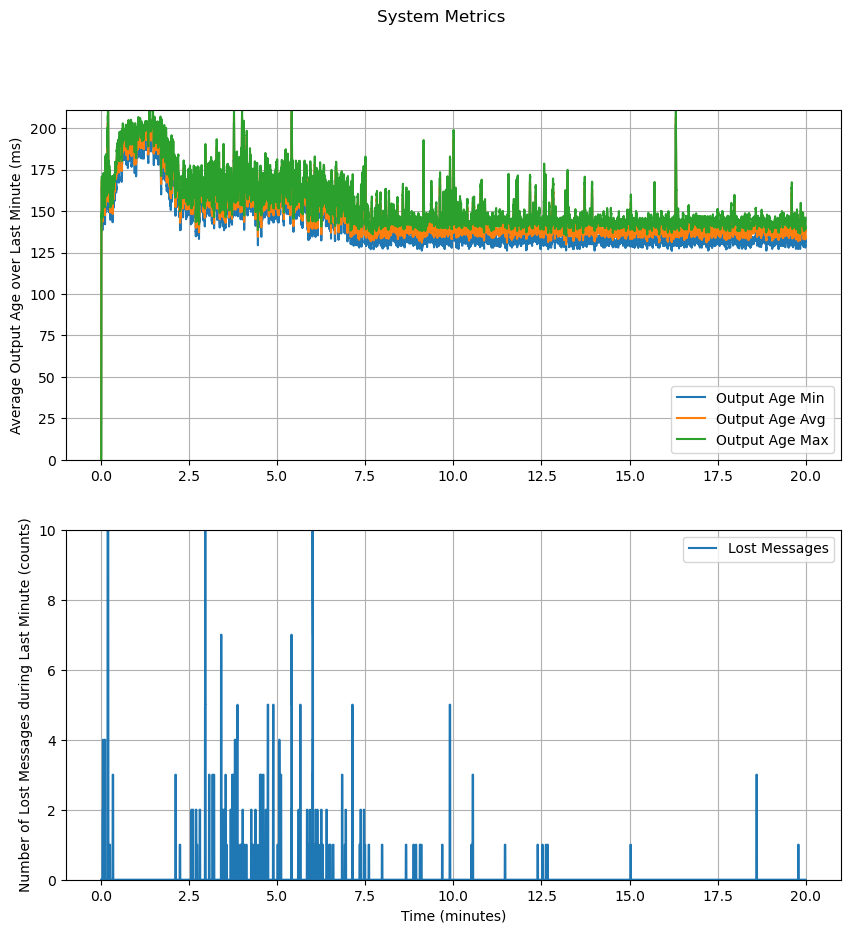

In [37]:
# Logging Configuration:
#   Data averaged / summed over 100 time-steps (=10s) window
#   Log to tensorboard every 100 time-steps (=10s). Without this, tensorboard would be our bottleneck.
writer = SummaryWriter(log_dir=str(LOG_PATH / "agent_default"))
logger = DataLogger(window_size=100, tensorboard_writer=writer, tensorboard_period=100)

# Run the training loop for 120_000 time-steps (=20min simulated time)
train(
    agent,
    env,
    120_000,
    params["agent"]["learn_period"],
    logger=logger,
    device=DEVICE
)

# Save the model
torch.save(agent.target_net.state_dict(), str(MODEL_PATH / f"agent_default.mdl"))

# Plot a summary of the result
fig, axs = plot_train_metrics(logger)
fix, axs = plot_system_metrics(logger)

In [8]:
env.nodes["SOURCE_2"]._sensor._disturbance = GaussianTimeSampler(0.0, 1.0, 5.0, 120.0)
logger.tensorboard_writer = SummaryWriter(log_dir=str(LOG_PATH / "model_1"))
train(
    agent,
    env,
    90_000,
    params["actor"]["learn_period"],
    logger=logger,
    device=DEVICE,
    reset=False
)
torch.save(agent.target_net.state_dict(), str(MODEL_PATH / f"model_1.mdl"))

100%|██████████| 90000/90000 [00:36<00:00, 2447.38it/s]


100%|██████████| 90000/90000 [00:36<00:00, 2490.89it/s]


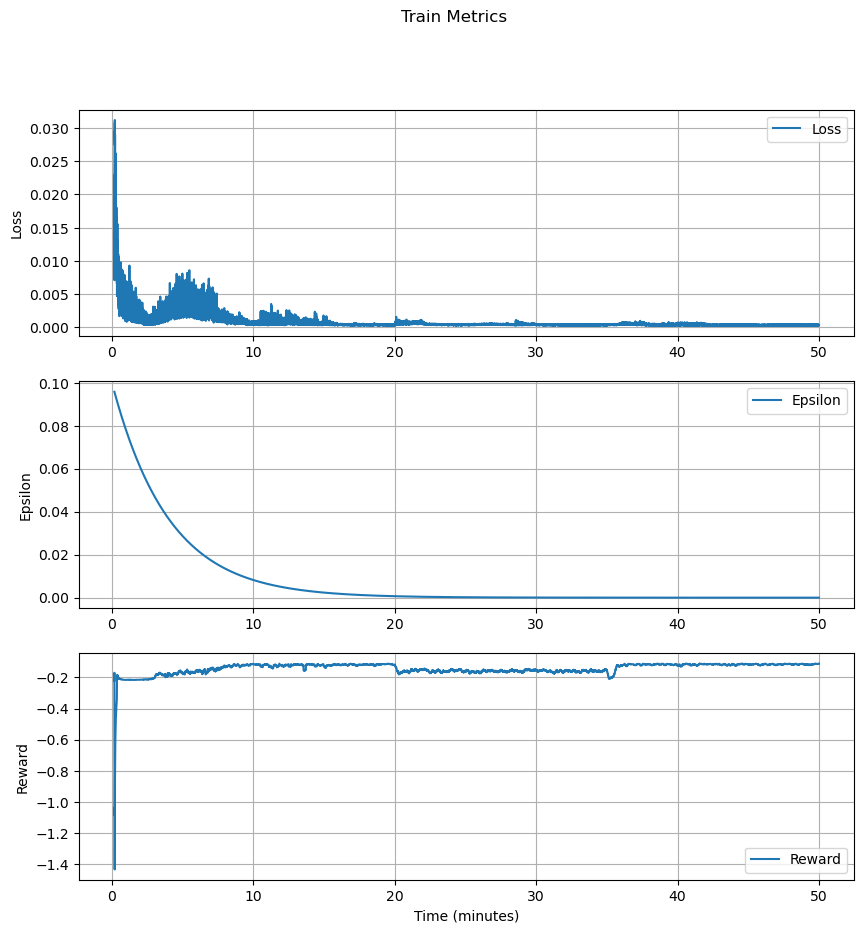

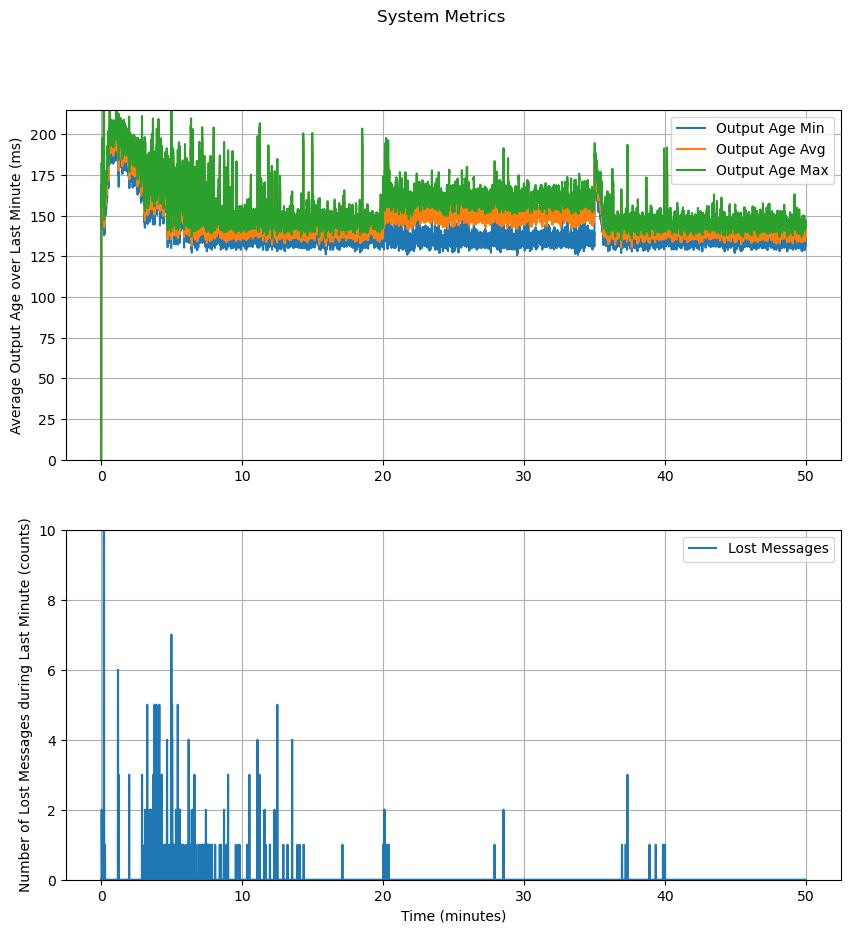

In [9]:
env.nodes[f"SOURCE_2"]._sensor._disturbance = FixedDuration(1e9)
logger.tensorboard_writer = SummaryWriter(log_dir=str(LOG_PATH / "model_2"))
train(
    agent,
    env,
    90_000,
    params["actor"]["learn_period"],
    logger=logger,
    device=DEVICE,
    reset=False
)
torch.save(agent.target_net.state_dict(), str(MODEL_PATH / f"model_2.mdl"))

TypeError: 'Text' object is not callable

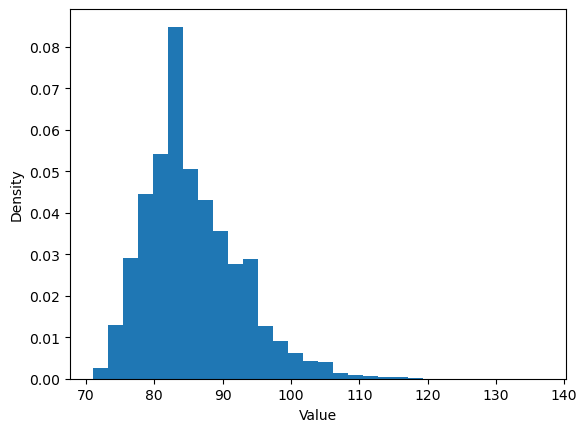

In [16]:
import numpy as np

import matplotlib.pyplot as plt

# Parameters of the gamma distribution
sampler = GammaDistributionSampler(5.0, 1.0, 3.1, 70.0)

samples = [sampler.sample() for _ in range(100000)]
fig, ax = plt.subplots(1, 1)
ax.hist(samples, bins=30, density=True)
ax.set_xlabel('Value')
ax.set_ylabel('Density')
ax.title('Gamma Distribution')

100%|██████████| 90000/90000 [00:36<00:00, 2472.60it/s]


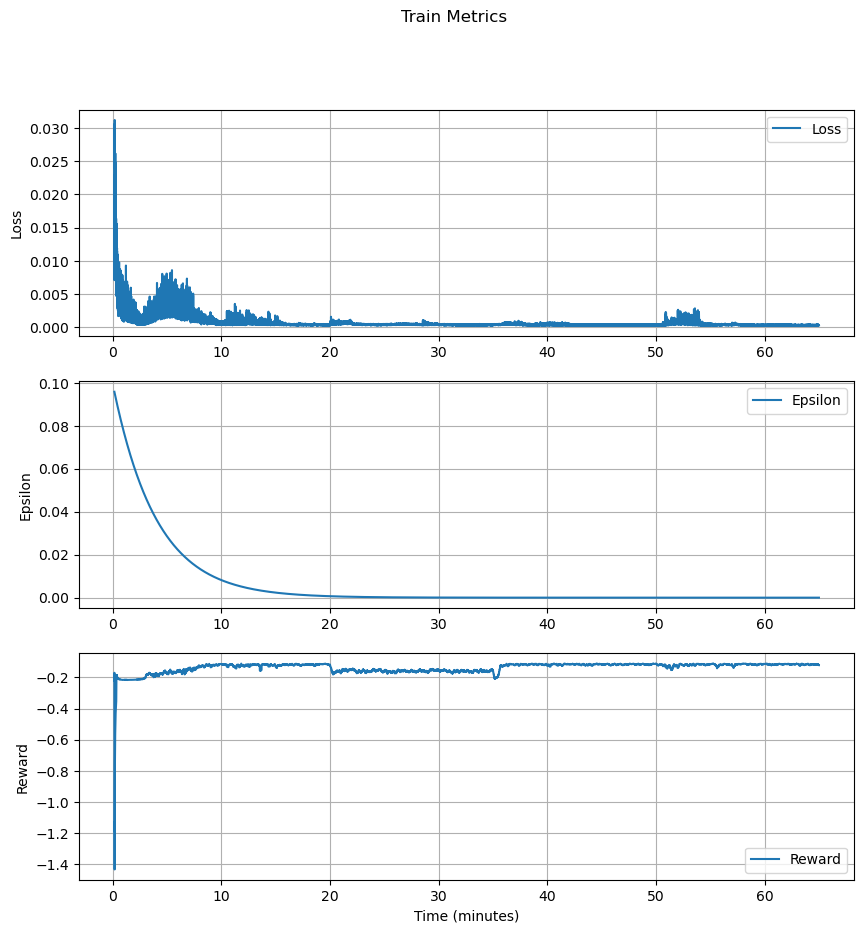

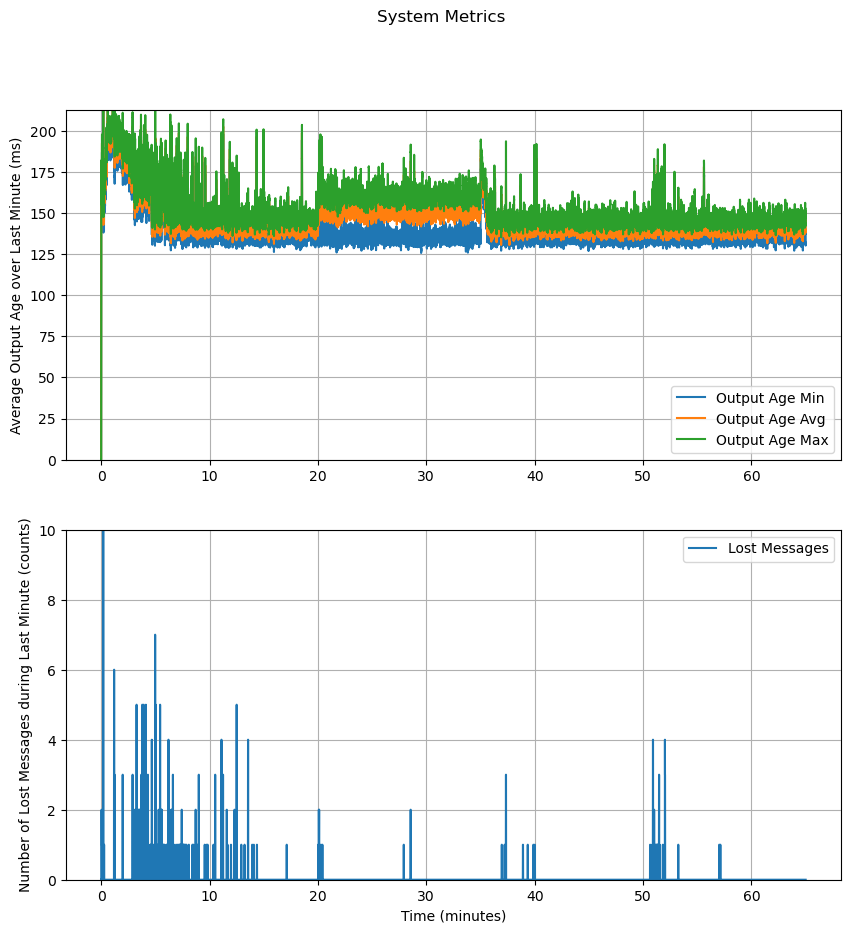

In [10]:
env.nodes[f"COMPUTE"]._duration_sampler = GammaDistributionSampler(5.0, 1.0, 3.0, 70.0)
logger.tensorboard_writer = SummaryWriter(log_dir=str(LOG_PATH / "model_3"))
train(
    agent,
    env,
    90_000,
    params["actor"]["learn_period"],
    logger=logger,
    device=DEVICE,
    reset=False
)
torch.save(agent.target_net.state_dict(), str(MODEL_PATH / f"model_3.mdl"))
fig, axs = plot_train_metrics(logger)
fix, axs = plot_system_metrics(logger)

In [11]:
# Simulate system, create gif, display here
#gif_creator = GifCreator()
#simulate(env, 100, gif_creator=gif_creator, interactive=True)
#gif_creator.save(str(IMG_PATH / "model_0.gif"), fps = 5)
#with open(str(IMG_PATH / 'model_0.gif'),'rb') as f:
#    display(Image(data=f.read(), format='png'))
